In [112]:
import tensorflow as tf
import os
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [113]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=25

In [114]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/sahilrathor/Downloads/Plant-Disease-Detection-Using-Machine-Learning-main/archive/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [115]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [116]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


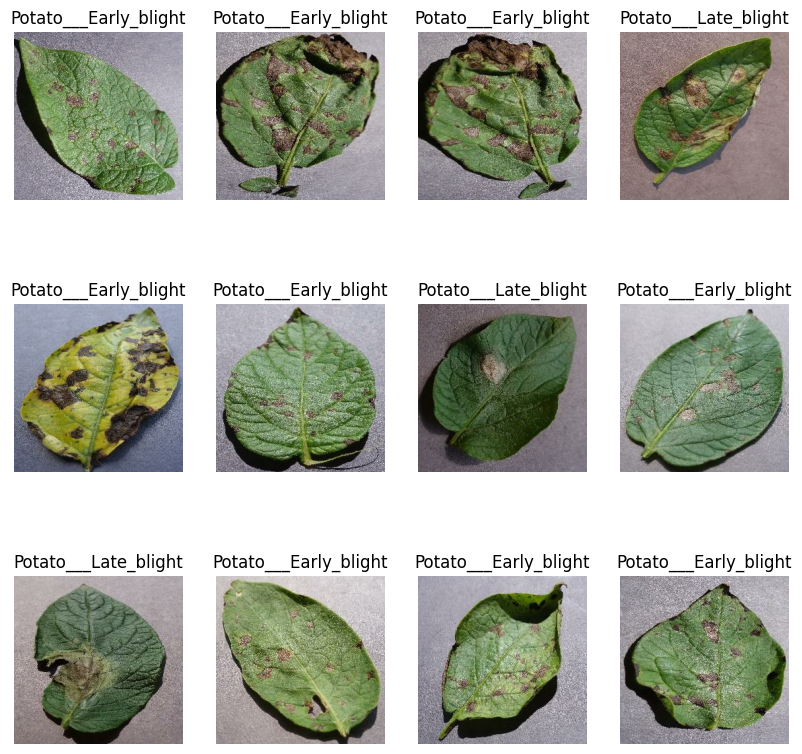

In [117]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [118]:
len(dataset)

68

In [119]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [120]:
train_ds = dataset.take(54)
len(train_ds)

54

In [121]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [122]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [123]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [124]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [125]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [126]:
len(train_ds)

54

In [127]:
len(val_ds)

6

In [128]:
len(test_ds)


8

In [129]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [130]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
])


In [131]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])


In [132]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [133]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='sigmoid'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='sigmoid'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [134]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 28, 28, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (32, 14, 14, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 12, 12, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (32, 6, 6, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 1152)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 3)                │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,491 (341.76 KB)

 Trainable params: 87,491 (341.76 KB)

 Non-trainable params: 0 (0.00 B)

In [135]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [136]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.4850 - loss: 0.9127 - val_accuracy: 0.4948 - val_loss: 0.8683
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6522 - loss: 0.7718 - val_accuracy: 0.6562 - val_loss: 0.8257
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 960ms/step - accuracy: 0.7610 - loss: 0.6010 - val_accuracy: 0.7656 - val_loss: 0.5642
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8258 - loss: 0.4653 - val_accuracy: 0.8542 - val_loss: 0.4393
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8310 - loss: 0.4256 - val_accuracy: 0.7188 - val_loss: 0.8124
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8565 - loss: 0.3630 - val_accuracy: 0.6771 - val_loss: 0.8890
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8918 - loss: 0.2878 - val_accuracy: 0.7812 - val_loss: 0.4709
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9340 - loss: 0.1805 - val_accuracy: 0.6771 - val_lo

In [137]:
scores= model.evaluate(test_ds)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - accuracy: 0.9102 - loss: 0.2664


In [138]:
scores


[0.2664465606212616, 0.91015625]

In [139]:
history

In [140]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [141]:
len(history.history['accuracy'])

25

In [142]:
acc=history.history['accuracy']
val_acc= history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

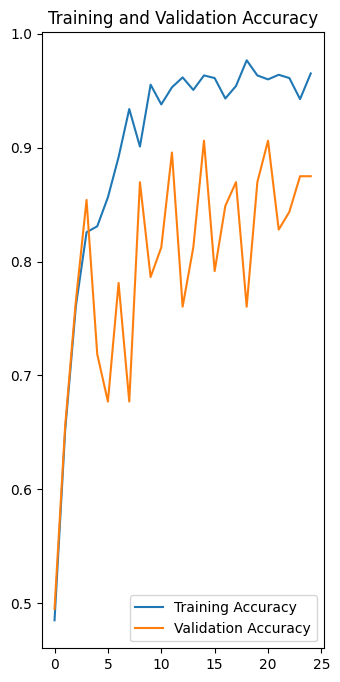

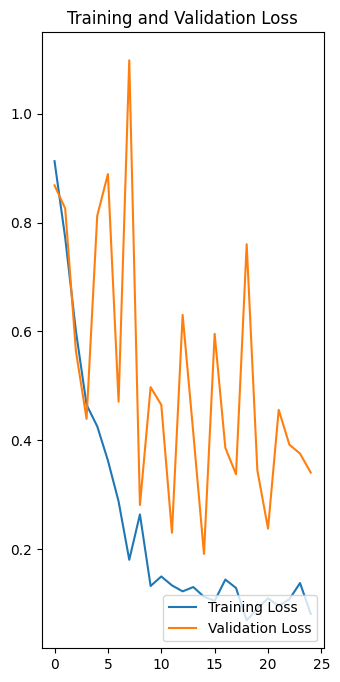

In [143]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

first image to predict
Actual label Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Potato___Late_blight


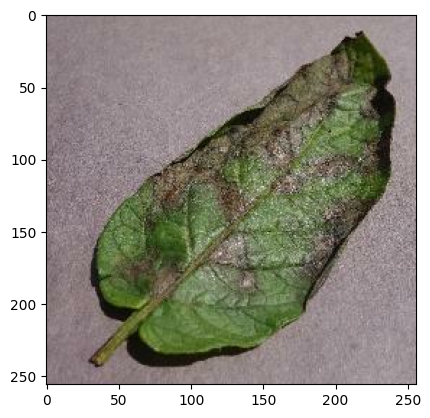

In [144]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('Actual label',class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [145]:
def predict(model,img):
    img_array =tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(batch_prediction[0])]
    confidence = round (100 * (np.max(predictions[0])),2)
    return predicted_class , confidence


2025-12-18 17:01:13.691897: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


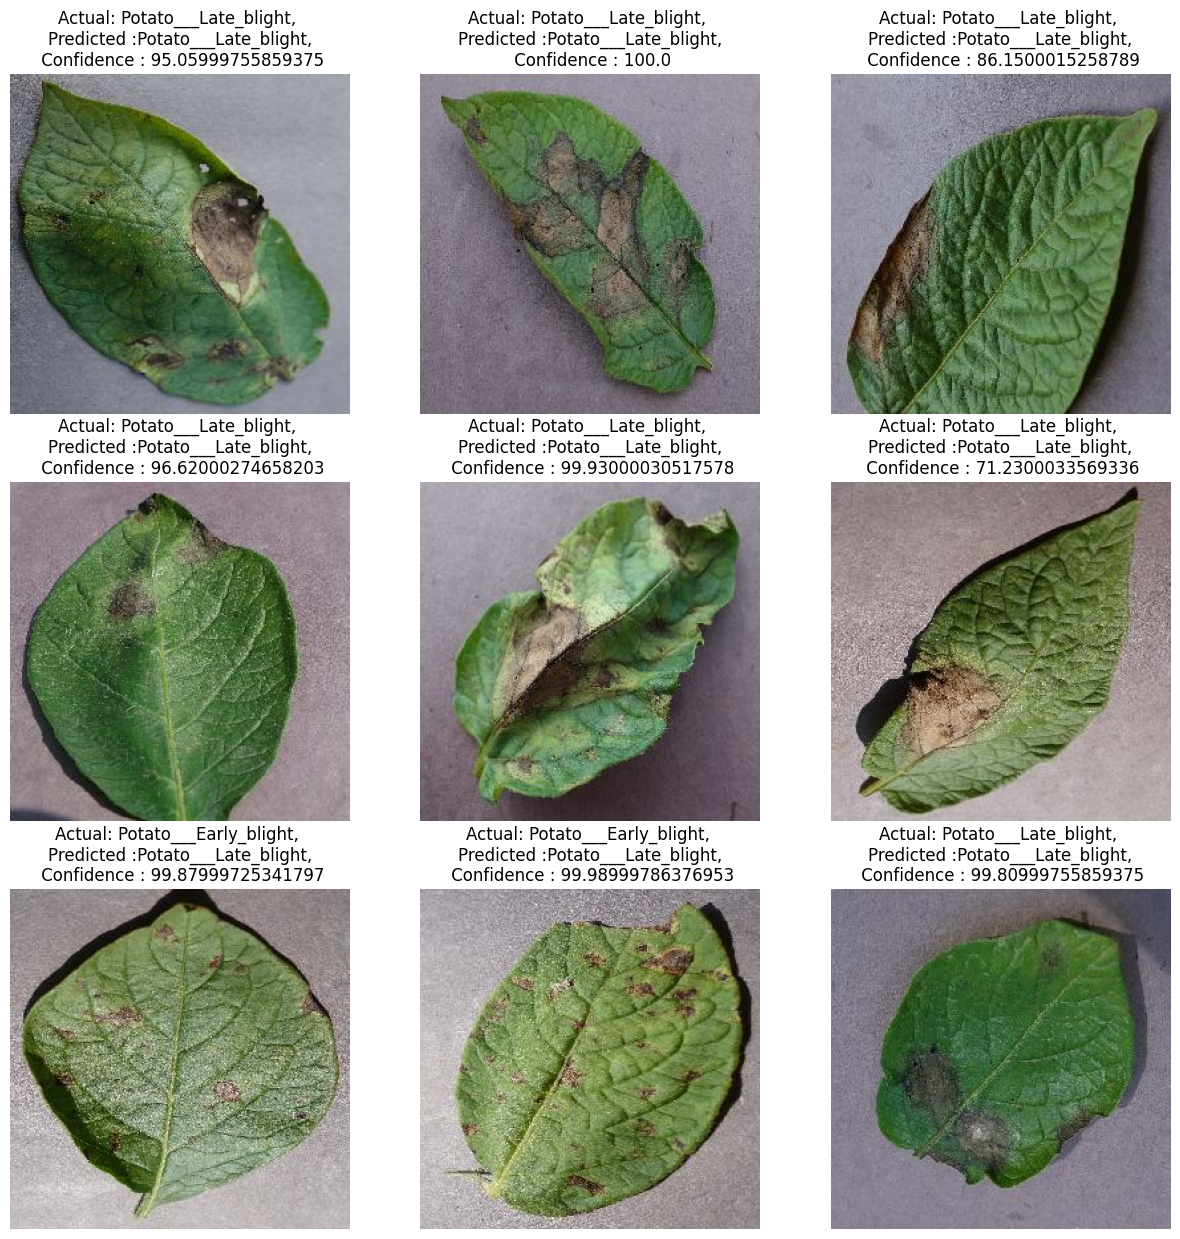

In [146]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence = predict(model,images[i].numpy())

        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \nPredicted :{predicted_class},\n Confidence : {confidence}")
        plt.axis('off')

In [147]:
import os

os.makedirs("../models", exist_ok=True)

model.save("../models/plant_disease_model_v1.keras")
